###1) Target:

Training accuracy dropped down in previous step. We want training accuracy to increase further. To accomplish this we will lower down dropout probability.

###2) Results:
Number of Parameters: 5,688 (previous 5,544)

Best Train Accuracy: 98.99 (was 98.36) (was 99.22) (previous 98.34) (previous 98.59)

Best Test Accuracy: 99.2 (was 99.12) (was 99.13) (previous98.46) (previous 98.56)

###3) Analysis:
Number of parameters remain same. 

We played around with dropout probabilities and lowered it down to just 2%.

There is an increase in training accuracy. 

There is an increase in test accuracy.

Model is still underfitting but to a lesser extent than it was in previous step.

Increase in training and test performance and reduction of extent of underfitting points to the importance of tuning dropouts properly.

However, we are still below our target accuracy of 99.4 in 15 epochs. We will try to introduce some image augmentation in next step.


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


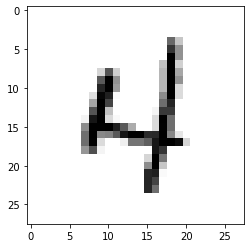

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

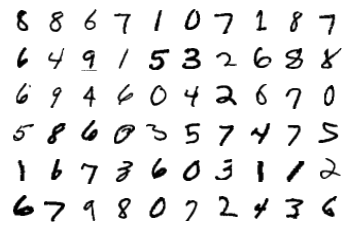

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [8]:
class Net(nn.Module):
    def __init__(self):

      super().__init__()
      
      self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, bias=False),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(inplace=True), #8*26*26
                                 nn.Dropout(0.02),
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(inplace=True), #16*24*24
                                 nn.Dropout(0.02)
      )

      self.trans = nn.Sequential(nn.MaxPool2d(2,2), #16*12*12
                                 nn.Conv2d(16,8,1, bias=False),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(inplace=True), #8*12*12
                                 nn.Dropout(0.02)
                                 )

      self.conv2 = nn.Sequential(nn.Conv2d(8, 8, 3, bias=False),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(inplace=True), #8*10*10
                                 nn.Dropout(0.02),
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(inplace=True), #16*8*8
                                 nn.Dropout(0.02),
                                 nn.Conv2d(16, 16, 3, bias=False),#16*6*6
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.02)
                                 )

      self.output = nn.Sequential(nn.Conv2d(16, 10, 1, bias=False)) #10*6*6
      self.avgpool2d = nn.AvgPool2d(kernel_size=6) #10*1*1


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans(x)
        x = self.conv2(x)
        x = self.output(x)
        x = self.avgpool2d(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing
 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.13210880756378174 Batch_id=468 Accuracy=77.76: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s]



Test set: Average loss: 0.1477, Accuracy: 9676/10000 (96.76%)

EPOCH: 1


Loss=0.18463265895843506 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:11<00:00, 41.79it/s]



Test set: Average loss: 0.0963, Accuracy: 9739/10000 (97.39%)

EPOCH: 2


Loss=0.09940128773450851 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:11<00:00, 42.18it/s]



Test set: Average loss: 0.0708, Accuracy: 9792/10000 (97.92%)

EPOCH: 3


Loss=0.1120525375008583 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]



Test set: Average loss: 0.0510, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.041706617921590805 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:10<00:00, 42.81it/s]



Test set: Average loss: 0.0479, Accuracy: 9859/10000 (98.59%)

EPOCH: 5


Loss=0.12911337614059448 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:11<00:00, 42.64it/s]



Test set: Average loss: 0.0365, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.01997092179954052 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 42.26it/s]



Test set: Average loss: 0.0338, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.024446770548820496 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]



Test set: Average loss: 0.0332, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.045638006180524826 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 43.13it/s]



Test set: Average loss: 0.0349, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.01211771834641695 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:10<00:00, 43.90it/s]



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.060104966163635254 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:10<00:00, 43.59it/s]



Test set: Average loss: 0.0307, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.02759033441543579 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:10<00:00, 42.90it/s]



Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.03606114536523819 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]



Test set: Average loss: 0.0284, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.05208785459399223 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:10<00:00, 42.81it/s]



Test set: Average loss: 0.0335, Accuracy: 9895/10000 (98.95%)

EPOCH: 14


Loss=0.02884509414434433 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s]



Test set: Average loss: 0.0293, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Test Accuracy')

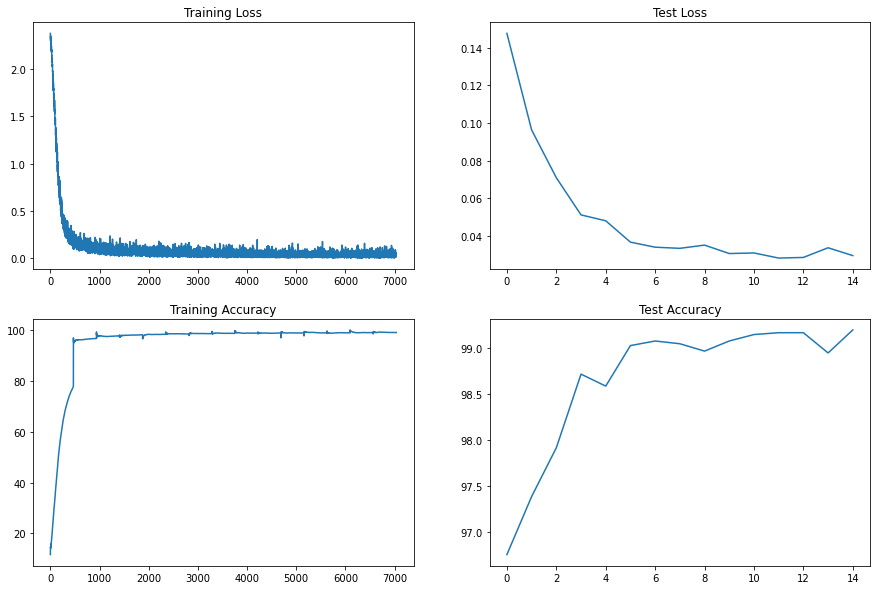

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")